In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CLASSES = 3
EPOCHS = 50

In [19]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    '../PlantVillages',
    shuffle = True,
    seed = 123,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    )

Found 2152 files belonging to 3 classes.


In [20]:
for image_batch, label_batch in data.take(1):
    print(image_batch.shape)
    print(label_batch)

(32, 255, 255, 3)
tf.Tensor([1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0], shape=(32,), dtype=int32)


In [21]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

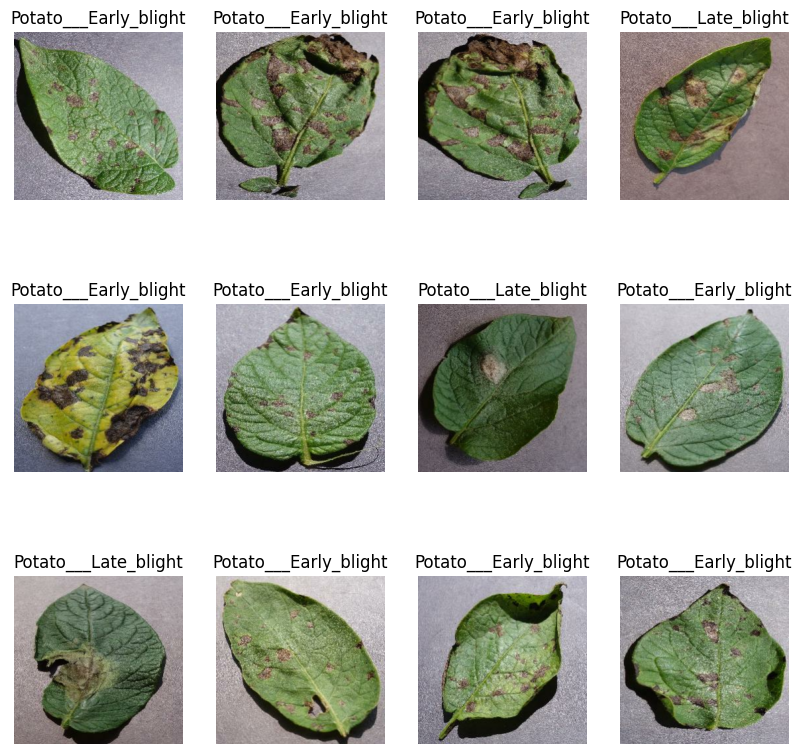

In [22]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [23]:
def splitdata(data, train_size=0.8, test_size=0.1, valid_size=0.1, shuffle=True):
    if shuffle:
        data = data.shuffle(buffer_size=10000, seed=123)

    total_count = 0
    for _ in data:
        total_count += 1

    train_count = int(train_size * total_count)
    test_count = int(test_size * total_count)
    valid_count = total_count - train_count - test_count

    train_ds = data.take(train_count)
    test_ds = data.skip(train_count).take(test_count)
    valid_ds = data.skip(train_count + test_count).take(valid_count)

    return train_ds, test_ds, valid_ds


In [24]:
train_ds, test_ds, valid_ds = splitdata(data)

In [25]:
len(train_ds)

54

In [26]:
resize_scaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
])

In [27]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [28]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [29]:
n_classes = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # Include channel dimension

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    resize_scaling,
    data_augmentation,
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),  # Softmax for multi-class
])


In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 sequential_1 (Sequential)   (None, 255, 255, 32)      0         
                                                                 
 sequential_2 (Sequential)   (None, 255, 255, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [31]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = valid_ds,
)

Epoch 1/50
54/54 [==============================] - 632s 11s/step - loss: 0.8951 - accuracy: 0.5164 - val_loss: 0.8980 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 537s 10s/step - loss: 0.7415 - accuracy: 0.6813 - val_loss: 0.6853 - val_accuracy: 0.6992
Epoch 3/50
54/54 [==============================] - 539s 10s/step - loss: 0.5529 - accuracy: 0.7535 - val_loss: 0.3544 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 533s 10s/step - loss: 0.3527 - accuracy: 0.8521 - val_loss: 0.3008 - val_accuracy: 0.8789
Epoch 5/50
54/54 [==============================] - 529s 10s/step - loss: 0.2742 - accuracy: 0.8891 - val_loss: 0.2351 - val_accuracy: 0.9141
Epoch 6/50
54/54 [==============================] - 526s 10s/step - loss: 0.2374 - accuracy: 0.9008 - val_loss: 0.2291 - val_accuracy: 0.9102
Epoch 7/50
54/54 [==============================] - 533s 10s/step - loss: 0.2143 - accuracy: 0.9120 - val_loss: 0.2391 - val_accuracy: 0.9023
Epoch 

In [33]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 14s 1s/step - loss: 0.1145 - accuracy: 0.9583


In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
loss = history.history['loss']
val_ac = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [37]:
len(acc)

50

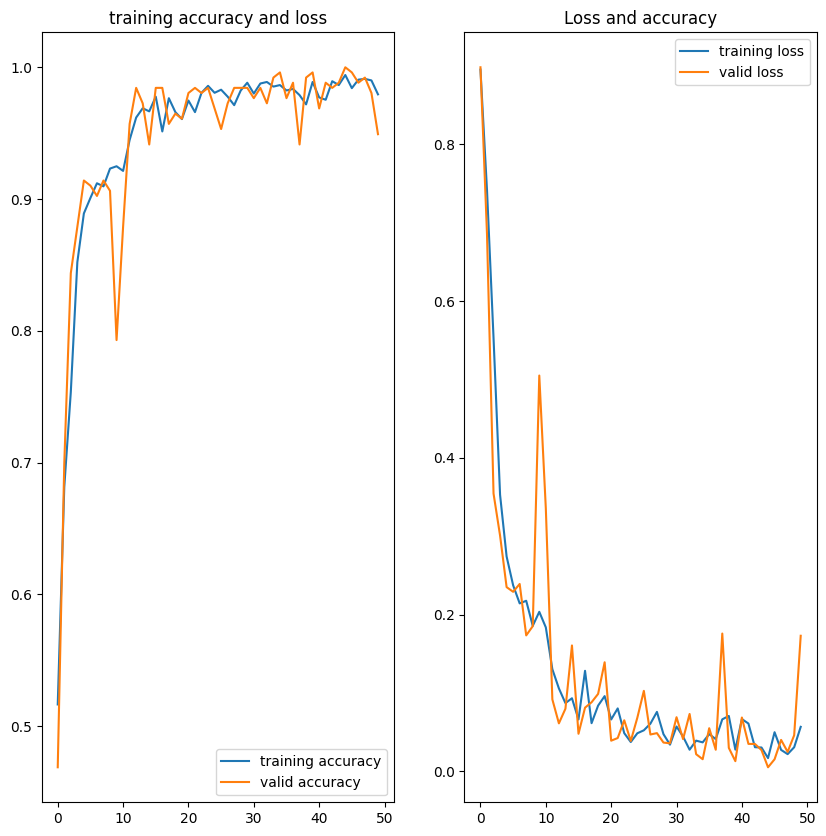

In [38]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'training accuracy')
plt.plot(range(EPOCHS), val_ac, label = 'valid accuracy')
plt.title('training accuracy and loss')
# plt.axis("off")
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label = 'valid loss')
plt.title('Loss and accuracy')
# plt.axis('off')
plt.legend(loc = 'upper right')
plt.show()


actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


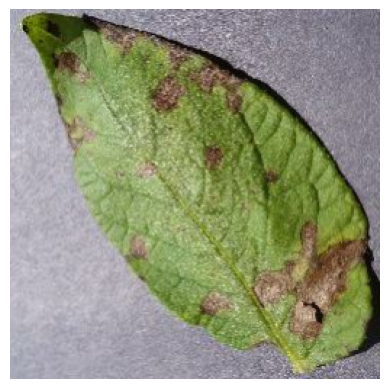

In [39]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    
    print(f"actual label: {class_names[label_batch[0]]}") 
    prediction = model.predict(image_batch)
    print(f"predicted label: {class_names[np.argmax(prediction[0])]}")
    plt.axis('off')

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return prediction_class, confidence

1/1 [==============================] - 0s 96ms/step


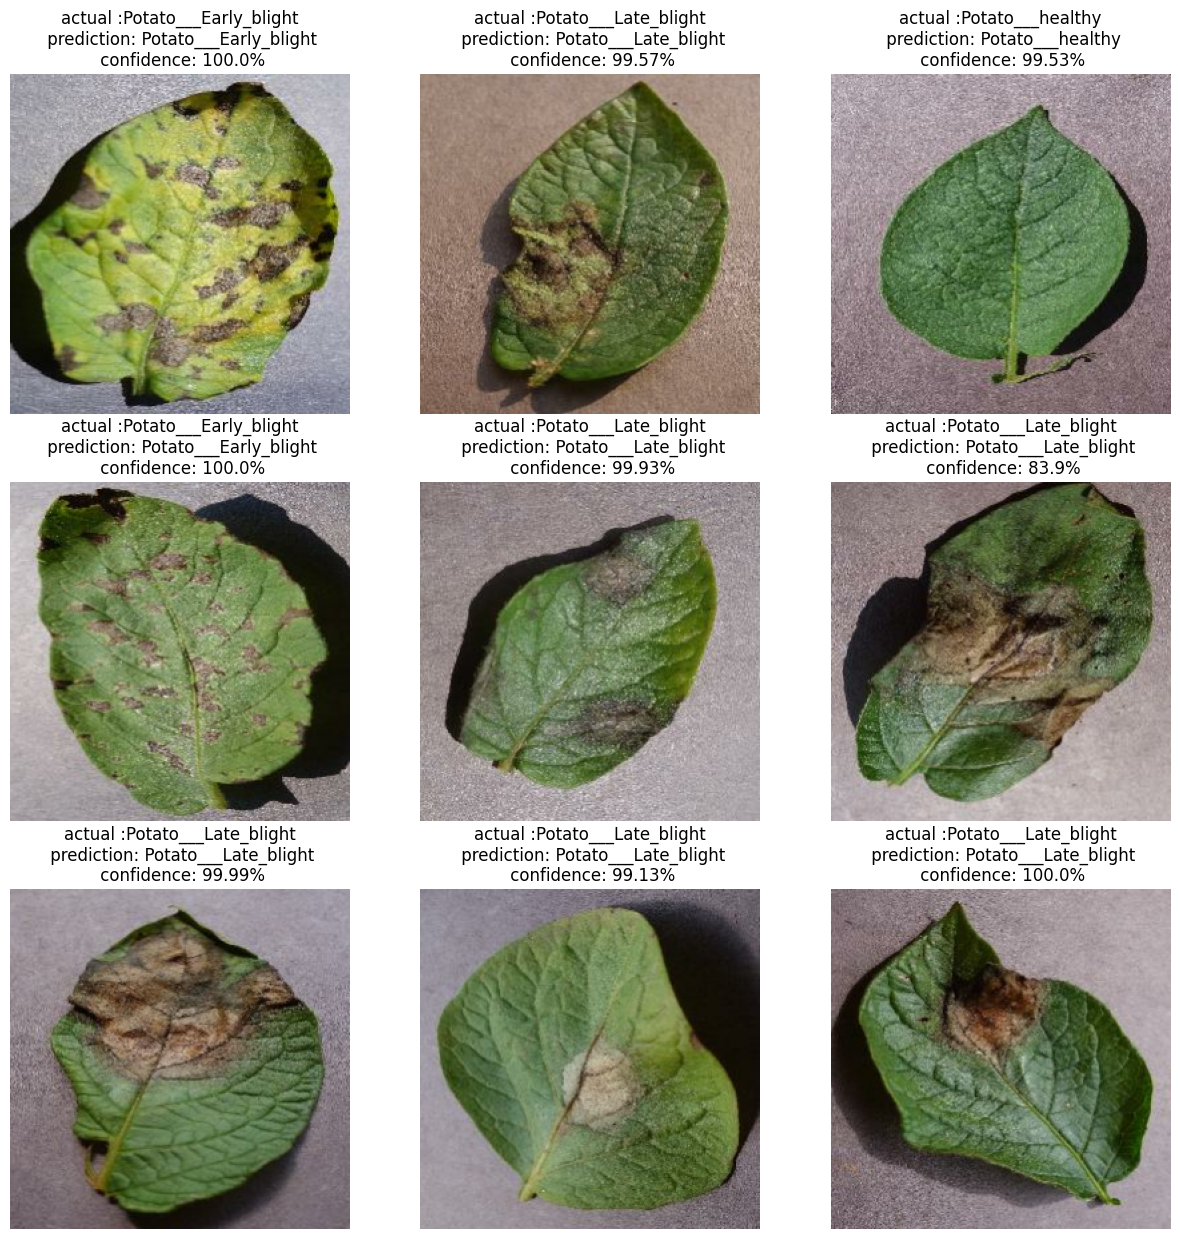

In [41]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        prediction_clas, confidence = predict(model, image_batch[i].numpy())
        actual_label = class_names[label_batch[i]]
        # print(f"actual label: {c}") 
        # print(f'prediction label: {prediction_clas}')
        # print(f'confidence:{confidence}') 
        plt.title(f"actual :{actual_label}\n prediction: {prediction_clas}\n confidence: {confidence}%"  )
        plt.axis('off')

In [45]:
import os 
model_version = max([int(i) for i in os.listdir("../saved_model")+ [0]]) +1
model.save(f"../saved_model/{model_version}")

INFO:tensorflow:Assets written to: ../saved_model/3\assets


INFO:tensorflow:Assets written to: ../saved_model/3\assets
